# I. IMPORT REQUIRED LIBRARIES

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import time
import pickle

# Plotation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Preprocessing Libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Model Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score,
    precision_score, recall_score, log_loss, precision_recall_curve, auc,
    classification_report
)

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss

# Hyperparameter Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    KFold, train_test_split, cross_val_score, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV
)
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Misc
from sklearn.metrics import make_scorer
from joblib import Parallel, delayed

# II. UPLOAD DATA

In [ ]:
# Bước 1: Tải dữ liệu
train_data_org = pd.read_csv('train.csv')
train = train_data_org.copy()
train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


# III. DATA PREPROCESSING

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scalers = {}
        self.policy_channel_mapping = None
        self.region_mapping = None
        self.upper_whisker = None

    def fit(self, X, y=None):
        # Xác định và lưu giới hạn trên cho 'Annual_Premium'
        Q1 = X['Annual_Premium'].quantile(0.25)
        Q3 = X['Annual_Premium'].quantile(0.75)
        IQR = Q3 - Q1
        self.upper_whisker = Q3 + 1.5 * IQR

        # Fit MinMaxScaler cho 'Annual_Premium' và 'Vintage'
        self.scalers['Annual_Premium'] = MinMaxScaler().fit(X[['Annual_Premium']])
        self.scalers['Vintage'] = MinMaxScaler().fit(X[['Vintage']])

        # Lưu các giá trị cho 'Policy_Sales_Channel' và 'Region_Code'
        policy_channel_counts = X['Policy_Sales_Channel'].value_counts()
        self.policy_channel_mapping = {k: 'Channel_A' if v > 100000 else 'Channel_B' if 74000 < v <= 100000 else 'Channel_C' if 10000 < v <= 74000 else 'Channel_D' for k, v in policy_channel_counts.items()}

        region_counts = X['Region_Code'].value_counts()
        self.region_mapping = {k: 'Region_A' if v >= 100000 else 'Region_B' if 11000 < v < 100000 else 'Region_C' for k, v in region_counts.items()}

        return self

    def transform(self, X, y=None):
        df = X.copy()

        # Xử lý ngoại lệ cho 'Annual_Premium'
        df['Annual_Premium'] = np.where(df['Annual_Premium'] > self.upper_whisker, self.upper_whisker, df['Annual_Premium'])

        # Chuyển đổi thuộc tính phân loại
        df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
        df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 1, '1-2 Year': 2, '> 2 Years': 3})
        df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

        # Áp dụng MinMaxScaler
        for feature, scaler in self.scalers.items():
            df[feature] = scaler.transform(df[[feature]])

        # Chuyển đổi 'Age', 'Policy_Sales_Channel', và 'Region_Code'
        df['Age'] = df['Age'].apply(lambda x: 1 if x >= 20 and x <= 34 else 2 if x > 34 and x <= 61 else 3)
        df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].map(lambda x: self.policy_channel_mapping.get(x, 'Channel_D')).map({'Channel_A': 1, 'Channel_B': 2, 'Channel_C': 3, 'Channel_D': 4})
        df['Region_Code'] = df['Region_Code'].map(lambda x: self.region_mapping.get(x, 'Region_C')).map({'Region_A': 1, 'Region_B': 2, 'Region_C': 3})

        return df


In [ ]:
# Bước 2: Khởi tạo và Fit DataPreprocessing
preprocessor = DataPreprocessing()
preprocessor.fit(train)

# Bước 3: Transform dữ liệu
train_full = preprocessor.transform(train)
train_full = train_full.drop(['id'], axis =1 )
train = train_full.copy()

# Hiển thị vài dòng đầu của dữ liệu đã được chuyển đổi
train.head(10)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,2,1,1,0,3,1,0.070366,2,0.716263,1
1,1,3,1,3,0,2,0,0.057496,2,0.598616,0
2,1,2,1,1,0,3,1,0.066347,2,0.058824,1
3,1,1,1,3,1,1,0,0.048348,1,0.667820,0
4,0,1,1,2,1,1,0,0.046259,1,0.100346,0
5,0,1,1,3,0,1,1,0.000000,3,0.574394,0
6,1,1,1,3,0,1,1,0.038578,1,0.826990,0
7,0,2,1,1,0,2,1,0.054696,2,0.214533,1
8,0,1,1,3,1,1,0,0.046488,1,0.062284,0
9,0,1,1,3,1,1,0,0.048631,1,0.242215,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  float64
 10  Response              381109 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 32.0 MB


In [ ]:
train.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,1.627461,0.997869,2.156979,0.458210,1.609616,0.504877,0.051193,2.241482,0.499472,0.122563
std,0.498336,0.665683,0.046110,0.831136,0.498251,0.567439,0.499977,0.028791,1.098346,0.289520,0.327936
min,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.040509,1.000000,0.249135,0.000000
50%,1.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.054023,2.000000,0.498270,0.000000
75%,1.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1.000000,0.068405,3.000000,0.750865,0.000000
max,1.000000,3.000000,1.000000,3.000000,1.000000,3.000000,1.000000,0.110249,4.000000,1.000000,1.000000


# IV. FEATURE IMPORTANCE SELECTION

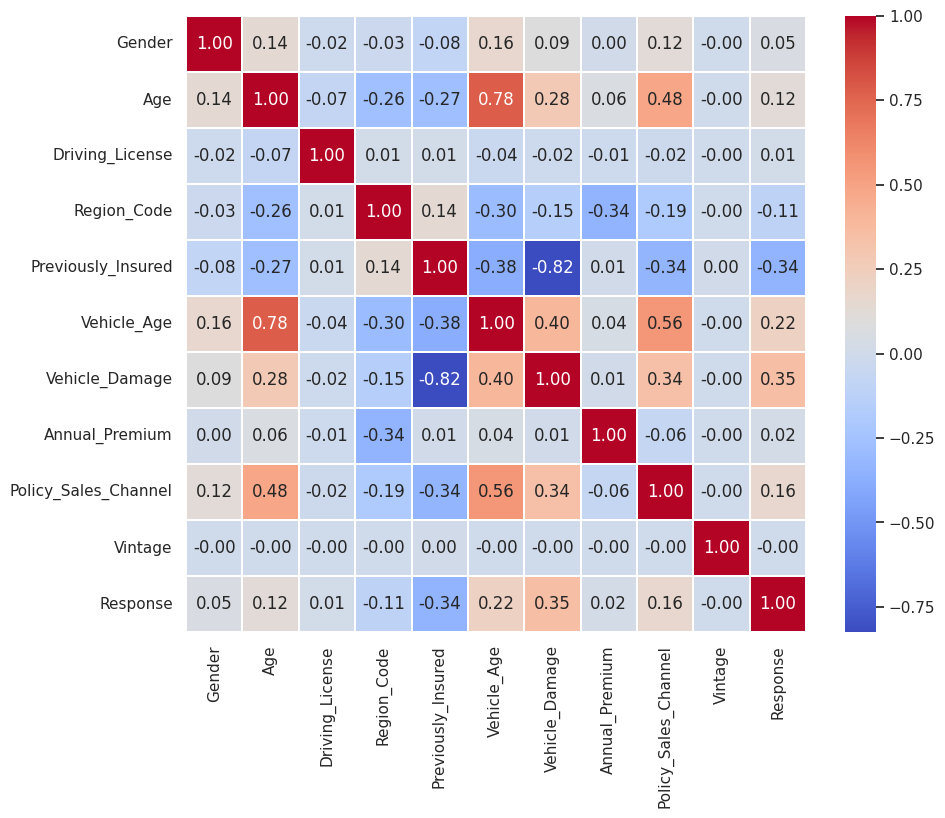

In [ ]:

corr = train.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the figure size (optional)
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,  # Annotate each cell with the numeric value
            cmap='coolwarm',  # Choose a color scheme
            fmt=".2f",  # Format for the annotations
            linewidths=.05)  # Space between cells

# Show the plot
plt.show()


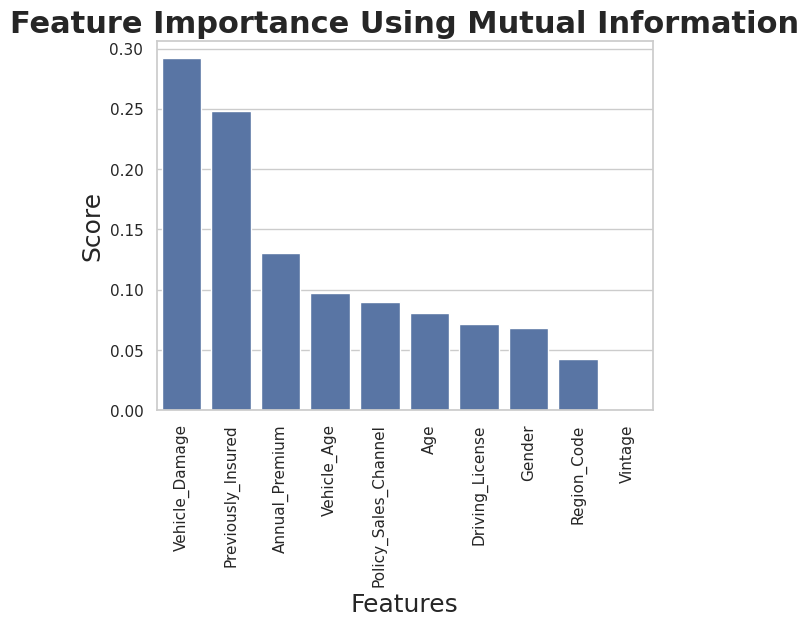

In [ ]:

def mutual_info(df):
    X = df.copy()
    y = X.pop("Response")

    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    X_ros.shape, y_ros.shape

    # Train và kiểm tra mô hình trên dữ liệu đã xử lý
    X_train, X_valid, y_train, y_valid = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

    high_score_features = []
    feature_scores = mutual_info_classif( X_ros, y_ros,  random_state=0)

    column_score = {}
    columns = []
    scores = []
    for score, f_name in sorted(zip(feature_scores, X_ros.columns), reverse=True):
        columns.append(f_name)
        scores.append(score)
        high_score_features.append(f_name)

    column_score['Feature'] = columns
    column_score['Score'] = scores

    return pd.DataFrame(data = column_score)

def show_feature_importance_through_mi(df):
    sns.barplot(data = mutual_info(df), x = 'Feature', y='Score')
    plt.title('Feature Importance Using Mutual Information', fontdict={'fontsize':22,'fontweight':'bold'})
    plt.xlabel('Features', fontdict={'fontsize':18})
    plt.ylabel('Score', fontdict={'fontsize':18})
    plt.xticks(rotation=90)

show_feature_importance_through_mi(train)


# V. EXPORT CSV TRAIN CLEAN

In [ ]:
train.to_csv('train_clean.csv', index = False)